<a href="https://colab.research.google.com/github/Jarvis-BITS/midodrine-mimic-iv/blob/demo/notebook/04a_psm_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
!pip install psmpy
!pip install pysmatch

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.cloud import bigquery
from causalml import match
from pysmatch.Matcher import Matcher
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
from sklearn.linear_model import LogisticRegression as lr
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

## do propensity score matching

### First way
For this method, you need to change the source code because it can't deal with the situation that 'age' propensity score equals 1
<br>Methods: make those who equal to 1 '-0.0001'

In [ ]:
psm = PsmPy(table_fillna, treatment='midodrine_injection', indx='stay_id', exclude = ['modality'])

In [ ]:
psm.logistic_ps(balance = True)

In [ ]:
psm.predicted_data

,stay_id,age,MICU,Gender,adm_weekday,weight,sapsii,charlson_index,CPD_or_COPD_rate,Maligancy_rate,...,temperature_mean,heart_rate_mean,resp_rate_mean,mbp_mean,sedative_use,ventilation_use,vasopressor_use,propensity_score,propensity_logit,midodrine_injection
0,30905391,18,1,0,5,67.5,13.000000,0.875000,0.0,0.0,...,37.887143,100.629630,20.685185,80.307692,0.0,0.0,0,0.434151,-0.264934,1
1,32861565,22,1,1,3,95.5,27.000000,1.000000,1.0,0.0,...,36.883750,94.970588,18.586207,69.034483,1.0,1.0,0,0.452236,-0.191639,1
2,37151963,21,0,0,7,66.0,23.000000,2.000000,0.0,0.0,...,37.199158,77.809140,16.806021,72.818566,1.0,1.0,1,0.716425,0.926796,1
3,38589648,23,0,0,1,62.5,11.000000,0.000000,0.0,0.0,...,37.820847,67.683761,15.519565,76.896552,1.0,1.0,1,0.557801,0.232243,1
4,37022074,23,1,1,6,78.0,21.000000,3.000000,1.0,0.0,...,36.250000,87.200000,22.591837,48.180000,0.0,1.0,0,0.632946,0.544877,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35295,34929118,91,0,1,4,70.0,40.000000,4.000000,0.0,0.0,...,36.761600,67.450000,13.735537,77.597701,0.0,1.0,0,0.029939,-3.478197,0
35296,31267720,91,0,0,1,72.0,43.000000,4.000000,0.0,0.0,...,36.828462,106.673913,16.565217,69.046512,0.0,0.0,0,0.185504,-1.479494,0
35297,37581409,91,1,1,3,62.5,67.000000,5.333333,0.0,0.0,...,36.434000,104.490566,28.711538,57.826087,0.0,0.0,0,0.056684,-2.811904,0
35298,36033310,91,0,1,2,50.0,33.000000,4.500000,0.0,0.0,...,36.384000,70.851064,21.553191,69.837209,0.0,1.0,0,0.006185,-5.079424,0


In [ ]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

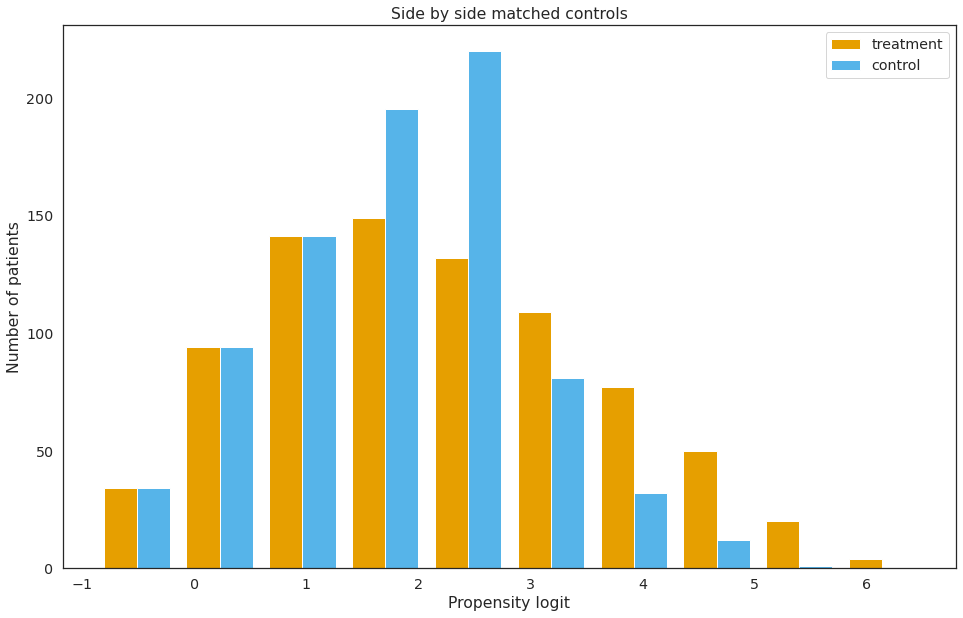

In [ ]:
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of patients', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)

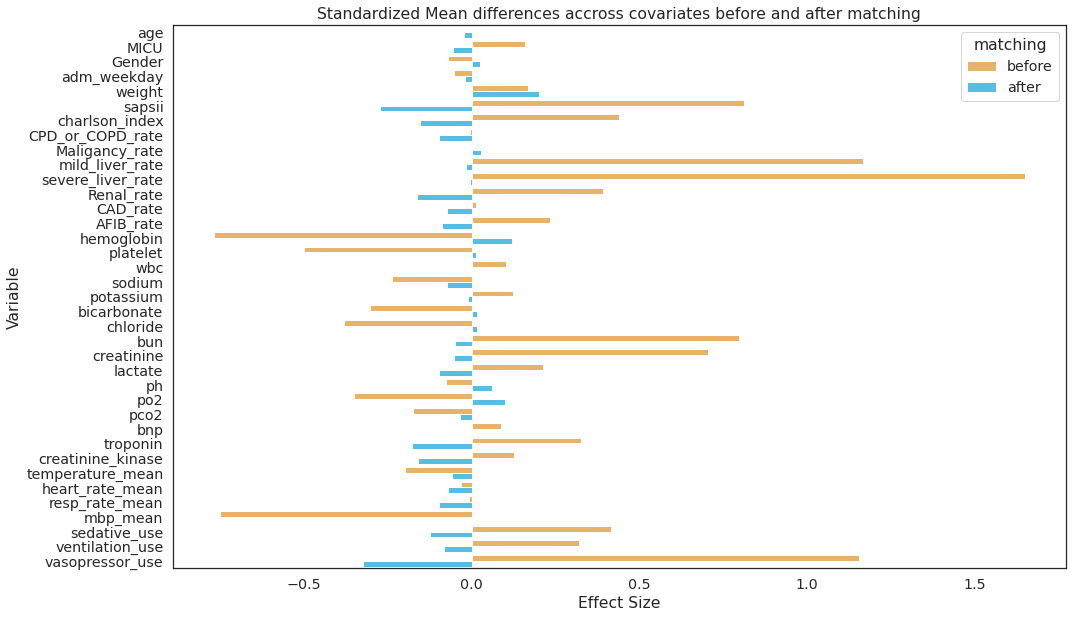

In [ ]:
psm.effect_size_plot(save=False)

In [ ]:
psm.matched_ids

,stay_id,matched_ID
0,30905391,31576783
1,32861565,30763434
2,37151963,33889924
3,38589648,31214569
4,37022074,31908598
...,...,...
805,39150002,36550047
806,38270869,39170419
807,35847016,30012243
808,37178815,33072984


### Second way
For this way, you don't need to worry about the 'age' problem, but you can't get the SMD directly and can't use stay_id for the index

In [ ]:
m = Matcher(mid_fillna, nomid_fillna, yvar="midodrine_injection", exclude=['stay_id', 'modality'])

Formula:
midodrine_injection ~ AFIB_rate+CAD_rate+CPD_or_COPD_rate+Gender+MICU+Maligancy_rate+Renal_rate+adm_weekday+anchor_age+bicarbonate+bnp+bun+charlson_index+chloride+creatinine+creatinine_kinase+heart_rate_mean+hemoglobin+lactate+mbp_mean+mild_liver_rate+pco2+ph+platelet+po2+potassium+resp_rate_mean+sapsii+sedative_use+severe_liver_rate+sodium+temperature_mean+troponin+vasopressor_use+ventilation_use+wbc
n majority: 34490
n minority: 810


In [ ]:
np.random.seed(20220614)

m.fit_scores(balance=True, nmodels=10,n_jobs = 5,model_type='tree')

This computer has: 2 cores , The workers should be :2
Fitting Models on Balanced Samples , model number :0Fitting Models on Balanced Samples , model number :2

Fitting Models on Balanced Samples , model number :3
Fitting Models on Balanced Samples , model number :1
Fitting Models on Balanced Samples , model number :4
Fitting Models on Balanced Samples , model number :6
Fitting Models on Balanced Samples , model number :5
Fitting Models on Balanced Samples , model number :7
Fitting Models on Balanced Samples , model number :8
Fitting Models on Balanced Samples , model number :9

Average Accuracy: 99.19%


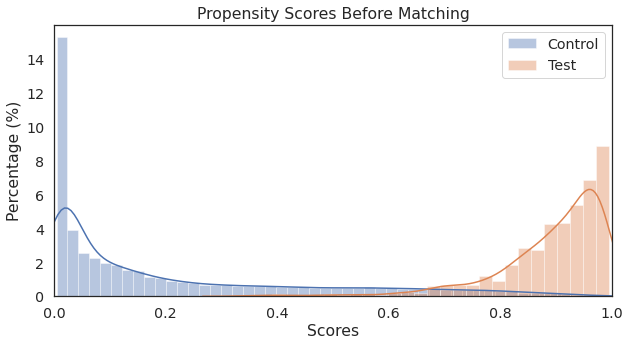

In [ ]:
m.predict_scores()
m.plot_scores()

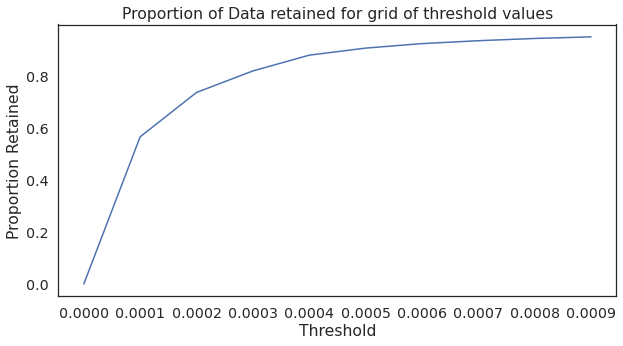

In [ ]:
m.tune_threshold(method='random')

In [ ]:
m.match(method="min", nmatches=1, threshold=0.0009)

In [ ]:
m.matched_data.sort_values("match_id")

,AFIB_rate,CAD_rate,CPD_or_COPD_rate,Gender,MICU,Maligancy_rate,Renal_rate,adm_weekday,anchor_age,bicarbonate,...,stay_id,temperature_mean,troponin,vasopressor_use,ventilation_use,wbc,weight,scores,match_id,record_id
0,0.0,0.0,0.0,0,1,0.0,0.0,5,18,27.000000,...,30905391,37.887143,0.000000,0,0.0,4.650000,67.5,0.782875,0,0
23965,1.0,1.0,1.0,0,0,0.0,0.0,5,72,27.444444,...,34310324,36.902903,1.000000,1,1.0,8.477778,98.0,0.782937,0,23965
1,0.0,0.0,1.0,1,1,0.0,0.0,3,21,22.000000,...,32861565,36.883750,0.000000,0,1.0,7.200000,95.5,0.557799,1,1
22861,0.0,0.0,0.0,0,0,1.0,0.0,2,70,23.500000,...,32773773,37.021000,0.000000,1,1.0,7.100000,72.1,0.557790,1,22861
2,1.0,0.0,0.0,0,0,0.0,0.0,7,21,26.035526,...,37151963,37.199158,0.750000,1,1.0,7.877451,66.0,0.855412,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16165,1.0,0.0,0.0,0,0,0.0,1.0,4,61,20.911765,...,37524325,36.646857,0.888889,1,1.0,6.048837,62.0,0.909697,807,16165
808,1.0,0.0,0.0,1,1,0.0,0.0,4,91,14.277778,...,37178815,36.353636,0.000000,1,1.0,21.408333,45.5,0.841848,808,808
14715,0.0,0.0,1.0,1,0,0.0,0.0,5,59,23.666667,...,34462762,36.708824,0.000000,1,1.0,14.633333,54.8,0.841793,808,14715
809,1.0,1.0,0.0,0,1,0.0,1.0,6,91,27.600000,...,35300383,36.620769,1.000000,1,1.0,6.733333,64.5,0.945542,809,809


## Extract matched no-midodrine data
Here I use the first way

In [ ]:
nomid_matched = table_init[table_init['stay_id'].isin(psm.matched_ids['matched_ID'])]

In [ ]:
nomid_matched.describe()

,stay_id,age,midodrine_injection,MICU,Gender,adm_weekday,weight,sapsii,charlson_index,CPD_or_COPD_rate,...,troponin,creatinine_kinase,temperature_mean,heart_rate_mean,resp_rate_mean,mbp_mean,sedative_use,ventilation_use,vasopressor_use,modality
count,8.100000e+02,810.000000,810.0,810.000000,810.000000,810.000000,795.000000,746.000000,810.000000,810.000000,...,810.000000,810.000000,806.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000
mean,3.496734e+07,63.064198,0.0,0.638272,0.422222,3.928395,80.107170,49.961126,6.673051,0.272840,...,0.388569,0.412592,36.817271,85.912138,19.650802,72.375225,0.648148,0.890123,0.850617,0.402469
std,2.852185e+06,9.946374,0.0,0.480798,0.494219,2.007971,22.223062,16.033768,2.356006,0.445694,...,0.469594,0.462609,0.533719,14.082745,3.799763,8.693164,0.477843,0.312929,0.356686,0.490698
min,3.000145e+07,27.000000,0.0,0.000000,0.000000,1.000000,1.000000,16.000000,0.000000,0.000000,...,0.000000,0.000000,32.220000,44.400000,10.986667,24.071429,0.000000,0.000000,0.000000,0.000000
25%,3.238670e+07,56.000000,0.0,0.000000,0.000000,2.000000,65.000000,38.000000,5.000000,0.000000,...,0.000000,0.000000,36.583816,76.292789,16.903049,67.210882,0.000000,1.000000,1.000000,0.000000
50%,3.509400e+07,63.000000,0.0,1.000000,0.000000,4.000000,77.000000,48.000000,6.500000,0.000000,...,0.000000,0.000000,36.842714,86.014682,19.359692,72.130589,1.000000,1.000000,1.000000,0.000000
75%,3.734337e+07,70.000000,0.0,1.000000,1.000000,6.000000,92.350000,60.000000,8.200000,1.000000,...,1.000000,1.000000,37.103442,94.438889,21.875938,77.293196,1.000000,1.000000,1.000000,1.000000
max,3.999887e+07,91.000000,0.0,1.000000,1.000000,7.000000,198.200000,105.000000,15.500000,1.000000,...,1.000000,1.000000,38.567500,132.283168,35.244186,106.755556,1.000000,1.000000,1.000000,1.000000


In [ ]:
nomid_group.describe()

,stay_id,age,midodrine_injection,MICU,Gender,adm_weekday,weight,sapsii,charlson_index,CPD_or_COPD_rate,...,troponin,creatinine_kinase,temperature_mean,heart_rate_mean,resp_rate_mean,mbp_mean,sedative_use,ventilation_use,vasopressor_use,modality
count,3.449000e+04,34490.000000,34490.0,34490.000000,34490.000000,34490.000000,33839.000000,25921.000000,34490.000000,34490.000000,...,34490.000000,34490.000000,34309.000000,34482.000000,34477.000000,34466.000000,34490.000000,34490.000000,34490.000000,34490.000000
mean,3.498527e+07,62.704001,0.0,0.532531,0.470658,3.995158,80.556065,34.683153,4.996305,0.233720,...,0.184064,0.284312,36.885414,85.390849,19.321163,80.610642,0.385938,0.719426,0.231168,0.167121
std,2.892301e+06,18.495629,0.0,0.498948,0.499146,1.995894,26.138540,14.199745,2.953193,0.423202,...,0.375603,0.437679,0.477306,14.804212,3.649900,11.035871,0.486823,0.449286,0.421586,0.373089
min,3.000015e+07,18.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,30.400000,29.807692,6.000000,24.071429,0.000000,0.000000,0.000000,0.000000
25%,3.245407e+07,51.000000,0.0,0.000000,0.000000,2.000000,64.700000,25.000000,3.000000,0.000000,...,0.000000,0.000000,36.658571,74.692308,16.695652,72.892133,0.000000,0.000000,0.000000,0.000000
50%,3.499529e+07,64.000000,0.0,1.000000,0.000000,4.000000,77.000000,33.000000,5.000000,0.000000,...,0.000000,0.000000,36.869286,84.751114,18.850000,79.900000,0.000000,1.000000,0.000000,0.000000
75%,3.749120e+07,77.000000,0.0,1.000000,1.000000,6.000000,92.000000,43.000000,7.000000,0.000000,...,0.000000,1.000000,37.126111,95.235091,21.474453,87.567889,1.000000,1.000000,0.000000,0.000000
max,3.999938e+07,102.000000,0.0,1.000000,1.000000,7.000000,1120.000000,114.000000,19.000000,1.000000,...,1.000000,1.000000,40.055000,167.000000,44.333333,139.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
psm.effect_size

,Variable,matching,Effect Size
0,age,before,0.004004
1,age,after,-0.022420
2,MICU,before,0.157571
3,MICU,after,-0.056081
4,Gender,before,-0.072314
...,...,...,...
69,sedative_use,after,-0.124663
70,ventilation_use,before,0.321002
71,ventilation_use,after,-0.082584
72,vasopressor_use,before,1.154151


## Save the results

In [ ]:
mid_group.describe().to_csv('/content/drive/MyDrive/midodrine_table1_results/mid_group.csv')
nomid_group.describe().to_csv('/content/drive/MyDrive/midodrine_table1_results/nomid_group.csv')
nomid_matched.describe().to_csv('/content/drive/MyDrive/midodrine_table1_results/nomid_matched.csv')
psm.effect_size.to_csv('/content/drive/MyDrive/midodrine_table1_results/psm_effect_size.csv')